# Testing eval.py

In [1]:
dev_mode = True   # A toggle that is only used for this notebook.
    # If copying code from notebook to python file, remove all the 'if dev_mode' blocks.
    # Any code that's only for te
    # sting purposes should be inside such a block.

### Code from the eval.py script

In [2]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np

import path   # adds repo to PATH
from modules.model import Rotated_cINN
from modules.data import RotatedMNIST

In [3]:
# Parameters
model_path = path.package_directory + "/trained_models/rotated_cinn5.pt"
analysis_path = path.package_directory + "/analysis/rotated_cinnx"
path.makedir(analysis_path)
device = 'cuda'  if torch.cuda.is_available() else  'cpu'
random_seed = 1
train_domains = [-23, 0, 23, 45, 90, 180]
test_domains = [-135, -90, -45, 10, 30, 60, 75, 135]
samples_per_domain = 100
ndim_total = 28 * 28
number_of_copies = 3   # number of samples displayed for each domain and class in the visual comparision

In [4]:
# Main functions
## Plotting losses
def show_domain_bar_plot(train_loss:dict[list], test_loss:dict[list]) -> None:

    fig, ax = plt.subplots(layout='constrained')

    # Spots for the bars on the x-axis
    test_spots = np.arange(len(test_loss['angles']))
    train_spots = np.nonzero(np.in1d(test_loss['angles'], train_loss['angles']))[0]
    width = 1/3  # the width of the bars
    
    # Train and test bars with error
    ax.bar(train_spots - width/2, train_loss['mean'], width=width, label='train')
    ax.errorbar(train_spots - width/2, train_loss['mean'], train_loss['err'], fmt=',', ecolor='black')
    ax.bar(test_spots + width/2, test_loss['mean'], width=width, label='test')
    ax.errorbar(test_spots + width/2, test_loss['mean'], test_loss['err'], fmt=',', ecolor='black')

    # Title, labels, etc.
    ax.set_title('MaxLikelihood loss of Rotated cINN')
    #ax.set_ylim(0, 1.1 * max(max(train_loss['angles']), max(test_loss['angles'])))
    ax.set_xticks(test_spots, labels=test_loss['angles'])
    ax.legend(loc='upper center', ncols=2)

    plt.savefig(analysis_path + "/domain_bar_plot.png")
    plt.show()

In [5]:
### Support functions for show_domain_bar_plot()
def compute_loss(model_output: torch.Tensor) -> tuple[float]:
    z, log_j = model_output
    losses = (z**2).mean(dim=1) / 2 - log_j / ndim_total
    std, mean = torch.std_mean(losses)
    mean_err = std / len(z)

    return (float(mean), float(mean_err))

In [6]:
def get_per_domain_loss(domains:list[int], dataset:RotatedMNIST, model:Rotated_cINN, number:int) -> dict[list]:
    loss_info = {'angles':domains, 'mean':[], 'err':[]}
    for domain in domains:
        domain_indices = torch.argwhere(domain == dataset.domain_labels)
        used_indices = domain_indices[:number].squeeze(1)
        
        data = dataset.data[used_indices]
        targets = dataset.targets[used_indices]
        output = model(data, targets)
        
        mean, err = compute_loss(output)
        loss_info['mean'].append(mean)
        loss_info['err'].append(err)

    return loss_info

In [7]:
## Showing generated images
def show_example_images():
    pass

In [8]:
# Main code
if __name__ == "__main__":
    torch.no_grad()
    
    # Load trained model
    cinn = Rotated_cINN().to(device)
    state_dict = {k:v for k,v in torch.load(model_path).items() if 'tmp_var' not in k}
    cinn.load_state_dict(state_dict)
    cinn.eval()

    # Load datasets
    all_domains = sorted(train_domains + test_domains)
    train_set = RotatedMNIST(domains=train_domains, train=True, seed=random_seed, val_set_size=1000)
    test_set = RotatedMNIST(domains=all_domains, train=False, seed=random_seed)


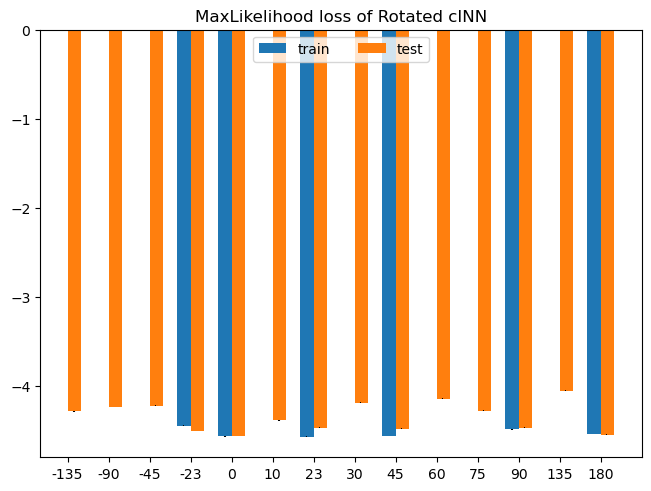

In [9]:
# Calculate loss for each domain
train_domain_loss = get_per_domain_loss(train_domains, train_set, cinn, samples_per_domain)
test_domain_loss = get_per_domain_loss(all_domains, test_set, cinn, samples_per_domain)

# Plot losses
show_domain_bar_plot(train_domain_loss, test_domain_loss)

In [10]:
# Compare test set images to generated ones

## Generate images from cinn
grid_shape = (len(train_domains), len(train_set.classes), number_of_copies)
if dev_mode:
    print(grid_shape)

### create cond tensor    
conditions = torch.zeros((*grid_shape, 12))   # for each image, the external condition for the cINN needs to be created
if dev_mode:
    print(conditions.shape)
    print(conditions[:, :, :, :2].shape)
domains_sincos = RotatedMNIST._deg2sincos(train_domains)
if dev_mode:
        print(domains_sincos.shape)
        print(domains_sincos[:, None, None, :].shape)
conditions[:, :, :, :2] = domains_sincos[:, None, None, :]
classes_onehot = torch.eye(10)
if dev_mode:
        print(conditions[:, :, :, 2:].shape)
        print(classes_onehot.shape)
        print(classes_onehot[None, :, None, :].shape)
conditions[:, :, :, 2:] = classes_onehot[None, :, None, :]

(6, 10, 3)
torch.Size([6, 10, 3, 12])
torch.Size([6, 10, 3, 2])
torch.Size([6, 2])
torch.Size([6, 1, 1, 2])
torch.Size([6, 10, 3, 10])
torch.Size([10, 10])
torch.Size([1, 10, 1, 10])


In [11]:
### cinn reverse
latent_tensor = torch.randn((*grid_shape, 28 * 28))
generated_images = torch.zeros([*grid_shape, 28, 28])
for d in range(grid_shape[0]):   # domains
    for c in range(grid_shape[1]):   # classes
        images, gradients = cinn.reverse(latent_tensor[d, c], conditions[d, c])
        generated_images[d, c] = images.squeeze(1).cpu().detach()   # remove batch dimension


if dev_mode:
    print(generated_images.shape) 

torch.Size([6, 10, 3, 28, 28])


In [12]:
'''#doesn't work
    ### cinn reverse
    latent_tensor = torch.randn((*grid_shape, 1, 28 * 28))
    generated_images = torch.zeros([*grid_shape, 1, 28, 28])
    generated_images, gradients = cinn.reverse(latent_tensor, conditions)
''';

In [13]:
print(images.shape, gradients.shape)
print(gradients)

torch.Size([3, 1, 28, 28]) torch.Size([3])
tensor([-3999.5105, -3084.9995, -2880.7214], grad_fn=<AddBackward0>)


In [14]:
## sample from train_set
### find enough samples for each domain-class pair
all_domain_indices = []
for domain in train_domains:
    domain_indices = torch.argwhere(domain == train_set.domain_labels)
    all_domain_indices.append(domain_indices)

all_class_indices = []
for class_label in train_set.classes:
    class_indices = torch.argwhere(class_label == train_set.class_labels)
    all_class_indices.append(class_indices)

all_domain_class_indices = torch.zeros(grid_shape, dtype=int)
for i in range(grid_shape[0]):   # domains
    for j in range(grid_shape[1]):   # classes
        class_mask = np.isin(all_domain_indices[i], all_class_indices[j])
        domain_class_indices = all_domain_indices[i][class_mask]
        all_domain_class_indices[i, j] = domain_class_indices[:grid_shape[2]]

sampled_images = train_set.data[all_domain_class_indices]

if dev_mode:
    print(sampled_images.shape)      


torch.Size([6, 10, 3, 28, 28])


In [15]:
## Display sampled and generated images side by side
### Reshape images for better display
    # [6, 10, 5, 28, 28] -> [6, 5, 28, 10, 28] -> [6, 140, 10, 28] -> [6, 140, 280]
if dev_mode:
    print(generated_images.shape)
    print(sampled_images.shape)
generated_image_grid = generated_images.movedim(1, 3).flatten(1, 2).flatten(2, 3)
sampled_image_grid = sampled_images.movedim(1, 3).flatten(1, 2).flatten(2, 3)
generated_image_grid = generated_image_grid.clamp(0, 1)
if dev_mode:
    print(generated_image_grid.shape)
    print(sampled_image_grid.shape)

torch.Size([6, 10, 3, 28, 28])
torch.Size([6, 10, 3, 28, 28])
torch.Size([6, 84, 280])
torch.Size([6, 84, 280])


[11. 12.]
(6,)


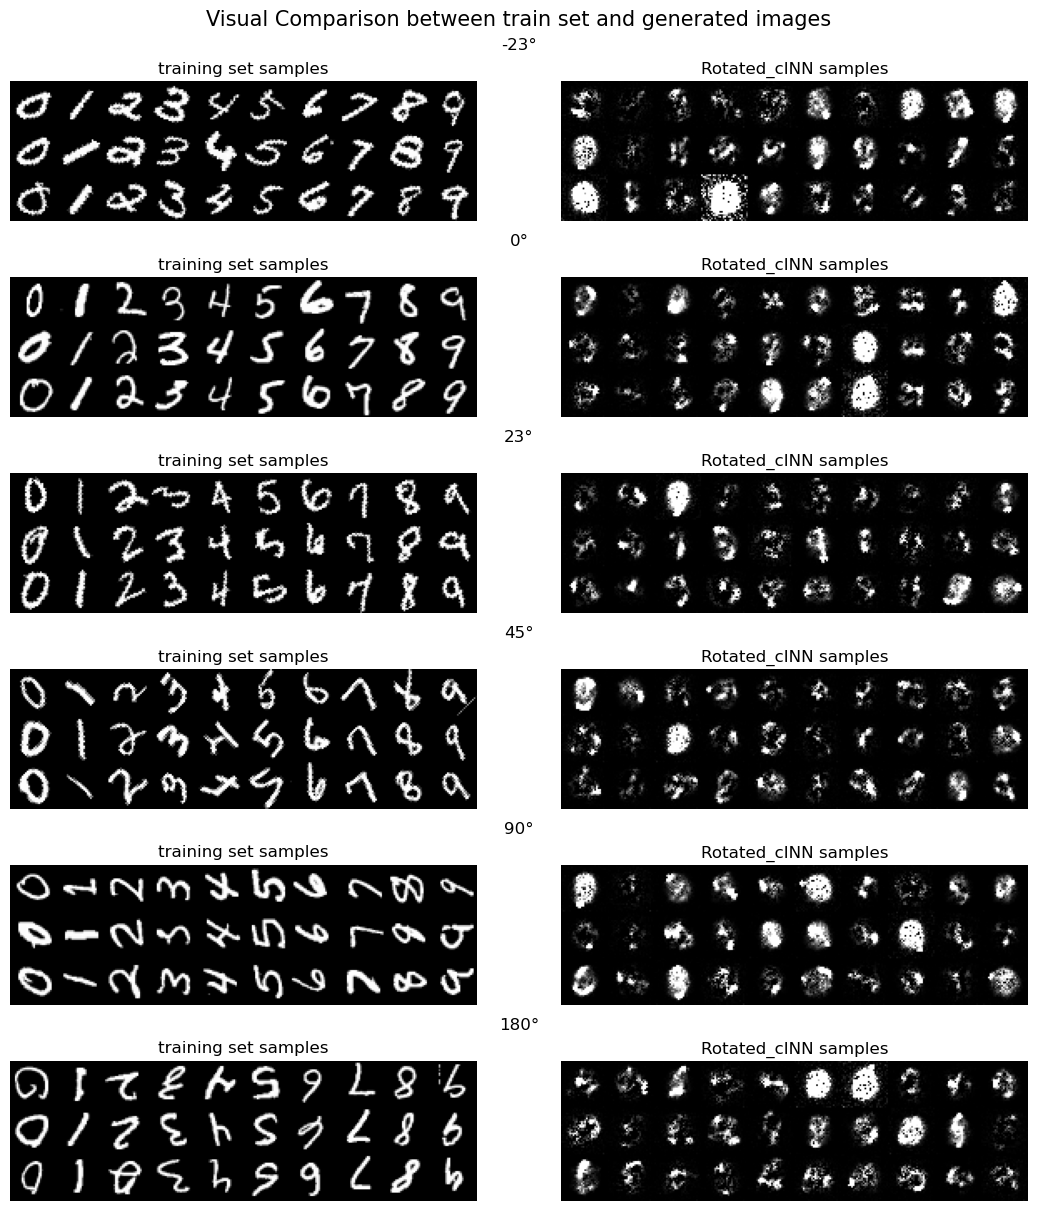

In [16]:

### Set plotting parameters
image_scaling = 0.5
subfigure_size = np.array([(2*grid_shape[1] + 2),   # 2x classes + middle column
                        (grid_shape[2] + 1)],    # rows + title
                    dtype=float) * image_scaling  
figure_size = subfigure_size * np.array([1, grid_shape[0]], dtype=float)
if dev_mode:
    print(figure_size)

### Plot visualizations, one domain after another
fig = plt.figure(figsize=figure_size, layout='constrained')
fig.suptitle("Visual Comparison between train set and generated images", fontsize=15)
subfigs = fig.subfigures(grid_shape[0], 1)
if dev_mode:
    print(subfigs.shape)

for d in range(grid_shape[0]):   # "for d in domains"
    figd = subfigs[d]
    figd.suptitle(f"{train_domains[d]}°")
    sub = figd.subplots(1, 2)

    sub[0].set_title("training set samples")
    sub[0].imshow(sampled_image_grid[d], cmap='gray')
    sub[0].axis('off')

    sub[1].set_title("Rotated_cINN samples")
    sub[1].imshow(generated_image_grid[d], cmap='gray')
    sub[1].axis('off')
fig.savefig(analysis_path + "/visual_comparison.png")
    
plt.show()

### Making small tests

In [33]:
print(generated_images.min(), generated_images.max())
print(generated_images.median(), generated_images.mean())

tensor(-64.1217) tensor(5180.1626)
tensor(0.0023) tensor(0.3728)


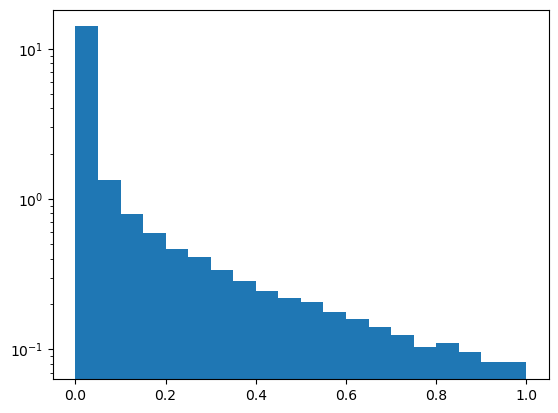

In [29]:
plt.hist(generated_images.flatten(), 20, range=(0, 1), log=True, density=True);

In [45]:
#test = sampled_images.transpose(2, 3)
test = sampled_images.movedim(1, 3)
print(test.shape)
test2 = test.flatten(1, 2)
print(test2.shape)
test3 = test2.flatten(2, 3)
print(test3.shape)

torch.Size([6, 5, 28, 10, 28])
torch.Size([6, 140, 10, 28])
torch.Size([6, 140, 280])


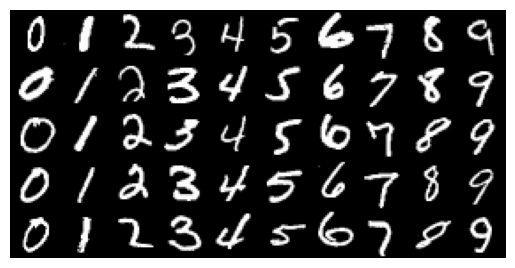

In [50]:
plt.imshow(test3[1], cmap='gray')  # domain 0°
plt.axis('off');

In [ ]:
all_domains

[-135, -90, -45, -23, 0, 10, 23, 30, 45, 60, 75, 90, 135, 180]

In [8]:
train_domain_loss

{'angles': [-23, 0, 23, 45, 90, 180],
 'mean': [-4.445914268493652,
  -4.565443992614746,
  -4.566565990447998,
  -4.558806419372559,
  -4.48470401763916,
  -4.53723669052124],
 'err': [0.0040816362015903,
  0.003116009524092078,
  0.0037074731662869453,
  0.00319852028042078,
  0.0030246952082961798,
  0.0035322392359375954]}

In [ ]:
domain = train_domains[0]
dataset = train_set
number = samples_per_domain
model = cinn


domain_indices = torch.argwhere(domain == dataset.domain_labels)
used_indices = domain_indices[:number].squeeze(1)
print(used_indices)
print(dataset.domain_labels[used_indices])

data = dataset.data[used_indices]
targets = dataset.targets[used_indices]
output = model(data, targets)
z, log_j = output
print(type(z), (z**2).mean(dim=1).shape)
print(type(log_j), log_j.shape)

mean, err = compute_loss(output)
print(mean, err)


tensor([  5,  11,  12,  16,  21,  33,  42,  46,  49,  55,  71,  77,  81,  91,
        101, 112, 115, 128, 132, 140, 142, 144, 148, 151, 153, 157, 162, 165,
        172, 175, 179, 181, 182, 185, 191, 195, 198, 203, 215, 220, 222, 237,
        241, 254, 259, 261, 272, 288, 290, 293, 294, 298, 299, 304, 308, 324,
        337, 339, 340, 342, 345, 348, 365, 370, 379, 383, 390, 393, 404, 407,
        411, 414, 427, 432, 435, 436, 455, 457, 463, 465, 470, 471, 472, 474,
        480, 492, 495, 504, 506, 510, 517, 521, 528, 532, 534, 537, 544, 561,
        568, 574])
tensor([-23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23, -23,
        -23, -23, -23, -23, -23, -23, -23, -2